In [1]:
import os
directory = '../../output.tara-delmont'
render='svg'
name=os.path.basename(directory)

In [2]:
from charcoal.utils import CSV_DictHelper
from IPython.display import display, Markdown

summary = CSV_DictHelper(f'{directory}/genome_summary.csv', 'genome')
display(Markdown(f"# charcoal summary report for `{name}`"))


# charcoal summary report for `output.tara-delmont`

In [3]:
import plotly.graph_objects as go
from charcoal import utils
import collections
import os

In [4]:
# calculate and display some basic statistics
summary = utils.CSV_DictHelper(f'{directory}/genome_summary.csv', 'genome')

all_genomes = set(summary)

n_genomes = len(all_genomes)
no_lineage = set([ k for k in all_genomes if not summary[k].lineage ])
n_no_lineage = len(no_lineage)
all_genomes -= no_lineage

no_genus_contam = set([ k for k in all_genomes if int(summary[k].bad_genus_bp) == 0 ])
n_no_contam = len(no_genus_contam)
all_genomes -= no_genus_contam
contaminated_list = set(all_genomes)
clean_list = set(no_genus_contam)

needs_lineage = [ k for k in no_lineage if int(summary[k].needs_lineage_flag) ]
n_needs_lineage = len(needs_lineage)

first_contam = {}
ignore = set()

for rank in 'superkingdom', 'phylum', 'class', 'order', 'family', 'genus':
    n = 0
    for genome in all_genomes:
        bad_bp = int(summary[genome][f'bad_{rank}_bp'])
        if genome in ignore:
            continue
        if bad_bp:
            n += 1
            ignore.add(genome)
            continue
    first_contam[rank] = n
    
def display_genome_list(names_to_show, order_by=None, reverse=True):
    # select only those we want to show
    values = [ summary[k] for k in names_to_show ]
    
    # sort by:
    if order_by:
        values.sort(key=lambda x: int(x[order_by]))
        if reverse: values.reverse()
    else:
        values.sort(key = lambda x: x.genome)
    
    output = []
    for row in values:
        output.append(f"* [`{row.genome}`]({row.genome}.fig.html)")
    
    return "\n".join(output)

def display_no_lineage_list():
    values = [ summary[k] for k in summary if not summary[k].lineage ]
    
    x = []
    for row in values:
        x.append(f"* `{row.genome}` - {row.comment}")
        
    return "\n".join(x)



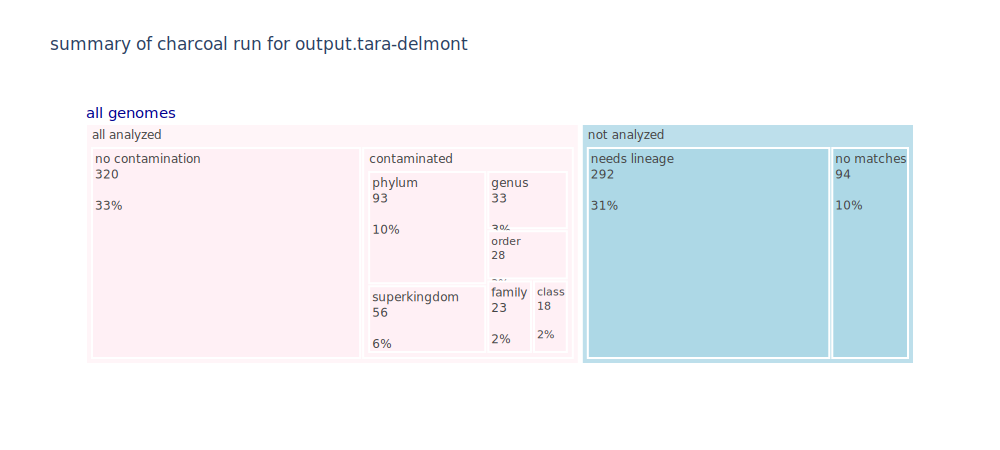

In [5]:
labels = ["all genomes", "all analyzed", "contaminated", "no contamination", "not analyzed", "no matches", "needs lineage"]
parents = [ "", "all genomes", "all analyzed", "all analyzed", "all genomes", "not analyzed", "not analyzed"]

# get basic numbers in --
values = [ len(summary),
           len(summary) - n_no_lineage,
           len(contaminated_list),
           n_no_contam,
           n_no_lineage,
           n_no_lineage - n_needs_lineage,
           n_needs_lineage,
           ]

# add per-rank breakdown
for rank in reversed(['superkingdom', 'phylum', 'class', 'order', 'family', 'genus']):
    labels.append(rank)
    parents.append('contaminated')
    values.append(first_contam[rank])
    
# display!

fig = go.Figure(go.Treemap(
    branchvalues = "total",
    labels = labels,
    parents = parents,
    values = values,
    textinfo = "label+value+percent entry",
    outsidetextfont = {"size": 20, "color": "darkblue"},
    marker = {"line": {"width": 2}},
    pathbar = {"visible": False}))

fig.update_layout(treemapcolorway = ["lavenderblush", "lightblue"],
                  title=f'summary of charcoal run for {name}')
fig.show(render, width=1000)


In [6]:
###### do display

display(Markdown(f"""
# Summary statistics

charcoal examined {n_genomes} total genomes in `{name}`.

{n_no_lineage} could not be analyzed for contamination; see Problem Report, below.

{n_no_contam} had no observed contamination at any taxonomic level down to genus.

Of the remaining {len(contaminated_list)} genomes,
* {first_contam['superkingdom']} had their first observed contamination at **superkingdom**;
* {first_contam['phylum']} had their first observed contamination at **phylum**;
* {first_contam['class']} had their first observed contamination at **class**;
* {first_contam['order']} had their first observed contamination at **order**;
* {first_contam['family']} had their first observed contamination at **family**;
* {first_contam['genus']} had their first observed contamination at **genus**.
"""))



# Summary statistics

charcoal examined 957 total genomes in `output.tara-delmont`.

386 could not be analyzed for contamination; see Problem Report, below.

320 had no observed contamination at any taxonomic level down to genus.

Of the remaining 251 genomes,
* 56 had their first observed contamination at **superkingdom**;
* 93 had their first observed contamination at **phylum**;
* 18 had their first observed contamination at **class**;
* 28 had their first observed contamination at **order**;
* 23 had their first observed contamination at **family**;
* 33 had their first observed contamination at **genus**.


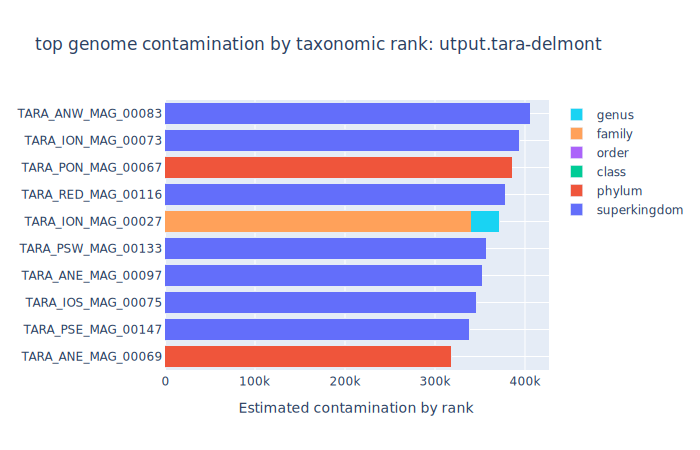

In [7]:
def make_hitlist_data(hit_list_filename, omit_genus=True, num=10):
    hits = utils.CSV_DictHelper(hit_list_filename, 'genome')
    
    endings = '.fna.gz', 'fa.gz', '.fa', '_genomic'
    
    # sort by sum of bad bp at specific rank
    if omit_genus:
        sort_by = 'family_bad_bp'
    else:
        sort_by = 'genus_bad_bp'
    
    # pick off the top num items, sorted by given sort_by
    items = list(hits.rows.items())
    items.sort(key=lambda item: -int(item[1][sort_by]))
    items = items[:num]
    items.reverse()
    
    hitlist_data = collections.defaultdict(list)
    names = hitlist_data['names']
    
    # for each item, retrieve all tax rank bp values
    for name, row in items:
        # clean up names:
        for end in endings:
            if name.endswith(end): name = name[:-len(end)]
        names.append(name)

        last_bp = 0
        for key in 'superkingdom', 'phylum', 'class', 'order', 'family', 'genus':
            bp = row[f'{key}_bad_bp']
            bp = int(bp)
            values = hitlist_data[key]
            values.append(bp - last_bp)
            last_bp = bp
            
    return hitlist_data

def plot_hitlist(hit_list_filename, omit_genus=True, num=10):
    hitlist_data = make_hitlist_data(hit_list_filename, omit_genus, num)
    
    names = hitlist_data['names']

    barchart_objs = []
    for key in 'superkingdom', 'phylum', 'class', 'order', 'family', 'genus':
        values = hitlist_data[key]
        if omit_genus and key == 'genus': break
            
        bc_obj = go.Bar(name=key, y=names, x=values, orientation='h')
        barchart_objs.append(bc_obj)
        
    fig = go.Figure(data=barchart_objs)
    title = f'top genome contamination by taxonomic rank: {os.path.dirname(hit_list_filename)[7:]}'
    fig.update_layout(barmode='stack', template='plotly',
                      xaxis_title='Estimated contamination by rank',
                      title=title)

    return fig

fig = plot_hitlist(f'{directory}/hit_list_for_filtering.csv', omit_genus=False)
if not render: render_name = None
else: render_name = render
fig.show(render_name)

In [8]:
display(Markdown(f"""
## Individual contamination reports

(Sorted by summed contamination at genus level.)

{display_genome_list(contaminated_list, 'bad_genus_bp')}

## Problem Report

{n_no_lineage} genomes could not be analyzed for contamination.

{display_no_lineage_list()}

## Analyzed genomes for which no removable contamination was detected

{n_no_contam} genomes had no removable contamination at any taxonomic level down to genus.

(Some of this could be due to cryptic contamination or chimeric contigs. @CTB document.)

{display_genome_list(clean_list)}

"""))


## Individual contamination reports

(Sorted by summed contamination at genus level.)

* [`TARA_ANW_MAG_00083.fa`](TARA_ANW_MAG_00083.fa.fig.html)
* [`TARA_ION_MAG_00073.fa`](TARA_ION_MAG_00073.fa.fig.html)
* [`TARA_PON_MAG_00067.fa`](TARA_PON_MAG_00067.fa.fig.html)
* [`TARA_RED_MAG_00116.fa`](TARA_RED_MAG_00116.fa.fig.html)
* [`TARA_ION_MAG_00027.fa`](TARA_ION_MAG_00027.fa.fig.html)
* [`TARA_PSW_MAG_00133.fa`](TARA_PSW_MAG_00133.fa.fig.html)
* [`TARA_ANE_MAG_00097.fa`](TARA_ANE_MAG_00097.fa.fig.html)
* [`TARA_IOS_MAG_00075.fa`](TARA_IOS_MAG_00075.fa.fig.html)
* [`TARA_PSE_MAG_00147.fa`](TARA_PSE_MAG_00147.fa.fig.html)
* [`TARA_ANE_MAG_00069.fa`](TARA_ANE_MAG_00069.fa.fig.html)
* [`TARA_PSW_MAG_00136.fa`](TARA_PSW_MAG_00136.fa.fig.html)
* [`TARA_ION_MAG_00072.fa`](TARA_ION_MAG_00072.fa.fig.html)
* [`TARA_PON_MAG_00064.fa`](TARA_PON_MAG_00064.fa.fig.html)
* [`TARA_RED_MAG_00103.fa`](TARA_RED_MAG_00103.fa.fig.html)
* [`TARA_RED_MAG_00118.fa`](TARA_RED_MAG_00118.fa.fig.html)
* [`TARA_PSE_MAG_00015.fa`](TARA_PSE_MAG_00015.fa.fig.html)
* [`TARA_PSE_MAG_00103.fa`](TARA_PSE_MAG_00103.fa.fig.html)
* [`TARA_ASE_MAG_00031.fa`](TARA_ASE_MAG_00031.fa.fig.html)
* [`TARA_PON_MAG_00085.fa`](TARA_PON_MAG_00085.fa.fig.html)
* [`TARA_PSE_MAG_00110.fa`](TARA_PSE_MAG_00110.fa.fig.html)
* [`TARA_PSE_MAG_00140.fa`](TARA_PSE_MAG_00140.fa.fig.html)
* [`TARA_RED_MAG_00063.fa`](TARA_RED_MAG_00063.fa.fig.html)
* [`TARA_PSW_MAG_00065.fa`](TARA_PSW_MAG_00065.fa.fig.html)
* [`TARA_PON_MAG_00054.fa`](TARA_PON_MAG_00054.fa.fig.html)
* [`TARA_ANE_MAG_00009.fa`](TARA_ANE_MAG_00009.fa.fig.html)
* [`TARA_ION_MAG_00032.fa`](TARA_ION_MAG_00032.fa.fig.html)
* [`TARA_ANE_MAG_00093.fa`](TARA_ANE_MAG_00093.fa.fig.html)
* [`TARA_RED_MAG_00072.fa`](TARA_RED_MAG_00072.fa.fig.html)
* [`TARA_PON_MAG_00075.fa`](TARA_PON_MAG_00075.fa.fig.html)
* [`TARA_RED_MAG_00115.fa`](TARA_RED_MAG_00115.fa.fig.html)
* [`TARA_ANE_MAG_00088.fa`](TARA_ANE_MAG_00088.fa.fig.html)
* [`TARA_PSW_MAG_00013.fa`](TARA_PSW_MAG_00013.fa.fig.html)
* [`TARA_IOS_MAG_00014.fa`](TARA_IOS_MAG_00014.fa.fig.html)
* [`TARA_RED_MAG_00114.fa`](TARA_RED_MAG_00114.fa.fig.html)
* [`TARA_ANW_MAG_00068.fa`](TARA_ANW_MAG_00068.fa.fig.html)
* [`TARA_ASE_MAG_00006.fa`](TARA_ASE_MAG_00006.fa.fig.html)
* [`TARA_SOC_MAG_00001.fa`](TARA_SOC_MAG_00001.fa.fig.html)
* [`TARA_PSE_MAG_00142.fa`](TARA_PSE_MAG_00142.fa.fig.html)
* [`TARA_RED_MAG_00109.fa`](TARA_RED_MAG_00109.fa.fig.html)
* [`TARA_ANE_MAG_00051.fa`](TARA_ANE_MAG_00051.fa.fig.html)
* [`TARA_PSW_MAG_00062.fa`](TARA_PSW_MAG_00062.fa.fig.html)
* [`TARA_ASE_MAG_00007.fa`](TARA_ASE_MAG_00007.fa.fig.html)
* [`TARA_ANE_MAG_00092.fa`](TARA_ANE_MAG_00092.fa.fig.html)
* [`TARA_PSW_MAG_00134.fa`](TARA_PSW_MAG_00134.fa.fig.html)
* [`TARA_PON_MAG_00077.fa`](TARA_PON_MAG_00077.fa.fig.html)
* [`TARA_PSW_MAG_00004.fa`](TARA_PSW_MAG_00004.fa.fig.html)
* [`TARA_ANW_MAG_00006.fa`](TARA_ANW_MAG_00006.fa.fig.html)
* [`TARA_PON_MAG_00071.fa`](TARA_PON_MAG_00071.fa.fig.html)
* [`TARA_RED_MAG_00065.fa`](TARA_RED_MAG_00065.fa.fig.html)
* [`TARA_PSE_MAG_00101.fa`](TARA_PSE_MAG_00101.fa.fig.html)
* [`TARA_ASW_MAG_00018.fa`](TARA_ASW_MAG_00018.fa.fig.html)
* [`TARA_PSE_MAG_00019.fa`](TARA_PSE_MAG_00019.fa.fig.html)
* [`TARA_ASE_MAG_00003.fa`](TARA_ASE_MAG_00003.fa.fig.html)
* [`TARA_PON_MAG_00082.fa`](TARA_PON_MAG_00082.fa.fig.html)
* [`TARA_RED_MAG_00004.fa`](TARA_RED_MAG_00004.fa.fig.html)
* [`TARA_RED_MAG_00069.fa`](TARA_RED_MAG_00069.fa.fig.html)
* [`TARA_ION_MAG_00029.fa`](TARA_ION_MAG_00029.fa.fig.html)
* [`TARA_ION_MAG_00034.fa`](TARA_ION_MAG_00034.fa.fig.html)
* [`TARA_PSE_MAG_00129.fa`](TARA_PSE_MAG_00129.fa.fig.html)
* [`TARA_PSE_MAG_00022.fa`](TARA_PSE_MAG_00022.fa.fig.html)
* [`TARA_MED_MAG_00139.fa`](TARA_MED_MAG_00139.fa.fig.html)
* [`TARA_RED_MAG_00104.fa`](TARA_RED_MAG_00104.fa.fig.html)
* [`TARA_ANE_MAG_00098.fa`](TARA_ANE_MAG_00098.fa.fig.html)
* [`TARA_PON_MAG_00061.fa`](TARA_PON_MAG_00061.fa.fig.html)
* [`TARA_RED_MAG_00014.fa`](TARA_RED_MAG_00014.fa.fig.html)
* [`TARA_PON_MAG_00004.fa`](TARA_PON_MAG_00004.fa.fig.html)
* [`TARA_ANE_MAG_00071.fa`](TARA_ANE_MAG_00071.fa.fig.html)
* [`TARA_RED_MAG_00071.fa`](TARA_RED_MAG_00071.fa.fig.html)
* [`TARA_ASE_MAG_00035.fa`](TARA_ASE_MAG_00035.fa.fig.html)
* [`TARA_ANE_MAG_00096.fa`](TARA_ANE_MAG_00096.fa.fig.html)
* [`TARA_PSW_MAG_00049.fa`](TARA_PSW_MAG_00049.fa.fig.html)
* [`TARA_PON_MAG_00029.fa`](TARA_PON_MAG_00029.fa.fig.html)
* [`TARA_IOS_MAG_00008.fa`](TARA_IOS_MAG_00008.fa.fig.html)
* [`TARA_PON_MAG_00023.fa`](TARA_PON_MAG_00023.fa.fig.html)
* [`TARA_PSE_MAG_00126.fa`](TARA_PSE_MAG_00126.fa.fig.html)
* [`TARA_PSE_MAG_00144.fa`](TARA_PSE_MAG_00144.fa.fig.html)
* [`TARA_ASW_MAG_00026.fa`](TARA_ASW_MAG_00026.fa.fig.html)
* [`TARA_ASE_MAG_00032.fa`](TARA_ASE_MAG_00032.fa.fig.html)
* [`TARA_PSE_MAG_00083.fa`](TARA_PSE_MAG_00083.fa.fig.html)
* [`TARA_PSE_MAG_00138.fa`](TARA_PSE_MAG_00138.fa.fig.html)
* [`TARA_MED_MAG_00130.fa`](TARA_MED_MAG_00130.fa.fig.html)
* [`TARA_ANW_MAG_00079.fa`](TARA_ANW_MAG_00079.fa.fig.html)
* [`TARA_ANE_MAG_00074.fa`](TARA_ANE_MAG_00074.fa.fig.html)
* [`TARA_PSW_MAG_00109.fa`](TARA_PSW_MAG_00109.fa.fig.html)
* [`TARA_ASE_MAG_00016.fa`](TARA_ASE_MAG_00016.fa.fig.html)
* [`TARA_ASW_MAG_00022.fa`](TARA_ASW_MAG_00022.fa.fig.html)
* [`TARA_PSE_MAG_00141.fa`](TARA_PSE_MAG_00141.fa.fig.html)
* [`TARA_MED_MAG_00128.fa`](TARA_MED_MAG_00128.fa.fig.html)
* [`TARA_ANW_MAG_00009.fa`](TARA_ANW_MAG_00009.fa.fig.html)
* [`TARA_PSE_MAG_00119.fa`](TARA_PSE_MAG_00119.fa.fig.html)
* [`TARA_ION_MAG_00014.fa`](TARA_ION_MAG_00014.fa.fig.html)
* [`TARA_ASW_MAG_00034.fa`](TARA_ASW_MAG_00034.fa.fig.html)
* [`TARA_PSE_MAG_00104.fa`](TARA_PSE_MAG_00104.fa.fig.html)
* [`TARA_RED_MAG_00021.fa`](TARA_RED_MAG_00021.fa.fig.html)
* [`TARA_MED_MAG_00125.fa`](TARA_MED_MAG_00125.fa.fig.html)
* [`TARA_PON_MAG_00072.fa`](TARA_PON_MAG_00072.fa.fig.html)
* [`TARA_ANE_MAG_00040.fa`](TARA_ANE_MAG_00040.fa.fig.html)
* [`TARA_ANE_MAG_00052.fa`](TARA_ANE_MAG_00052.fa.fig.html)
* [`TARA_ANW_MAG_00085.fa`](TARA_ANW_MAG_00085.fa.fig.html)
* [`TARA_ASW_MAG_00012.fa`](TARA_ASW_MAG_00012.fa.fig.html)
* [`TARA_PON_MAG_00065.fa`](TARA_PON_MAG_00065.fa.fig.html)
* [`TARA_PSW_MAG_00096.fa`](TARA_PSW_MAG_00096.fa.fig.html)
* [`TARA_ANE_MAG_00080.fa`](TARA_ANE_MAG_00080.fa.fig.html)
* [`TARA_PSE_MAG_00118.fa`](TARA_PSE_MAG_00118.fa.fig.html)
* [`TARA_ANE_MAG_00078.fa`](TARA_ANE_MAG_00078.fa.fig.html)
* [`TARA_PON_MAG_00015.fa`](TARA_PON_MAG_00015.fa.fig.html)
* [`TARA_ANE_MAG_00039.fa`](TARA_ANE_MAG_00039.fa.fig.html)
* [`TARA_IOS_MAG_00038.fa`](TARA_IOS_MAG_00038.fa.fig.html)
* [`TARA_MED_MAG_00058.fa`](TARA_MED_MAG_00058.fa.fig.html)
* [`TARA_RED_MAG_00050.fa`](TARA_RED_MAG_00050.fa.fig.html)
* [`TARA_PSE_MAG_00106.fa`](TARA_PSE_MAG_00106.fa.fig.html)
* [`TARA_ASE_MAG_00014.fa`](TARA_ASE_MAG_00014.fa.fig.html)
* [`TARA_ION_MAG_00058.fa`](TARA_ION_MAG_00058.fa.fig.html)
* [`TARA_PON_MAG_00053.fa`](TARA_PON_MAG_00053.fa.fig.html)
* [`TARA_ION_MAG_00067.fa`](TARA_ION_MAG_00067.fa.fig.html)
* [`TARA_PSE_MAG_00120.fa`](TARA_PSE_MAG_00120.fa.fig.html)
* [`TARA_ASW_MAG_00011.fa`](TARA_ASW_MAG_00011.fa.fig.html)
* [`TARA_IOS_MAG_00033.fa`](TARA_IOS_MAG_00033.fa.fig.html)
* [`TARA_PSW_MAG_00012.fa`](TARA_PSW_MAG_00012.fa.fig.html)
* [`TARA_IOS_MAG_00022.fa`](TARA_IOS_MAG_00022.fa.fig.html)
* [`TARA_ANW_MAG_00011.fa`](TARA_ANW_MAG_00011.fa.fig.html)
* [`TARA_IOS_MAG_00067.fa`](TARA_IOS_MAG_00067.fa.fig.html)
* [`TARA_ANE_MAG_00081.fa`](TARA_ANE_MAG_00081.fa.fig.html)
* [`TARA_PSE_MAG_00133.fa`](TARA_PSE_MAG_00133.fa.fig.html)
* [`TARA_PON_MAG_00066.fa`](TARA_PON_MAG_00066.fa.fig.html)
* [`TARA_ANW_MAG_00075.fa`](TARA_ANW_MAG_00075.fa.fig.html)
* [`TARA_PSE_MAG_00097.fa`](TARA_PSE_MAG_00097.fa.fig.html)
* [`TARA_PON_MAG_00044.fa`](TARA_PON_MAG_00044.fa.fig.html)
* [`TARA_MED_MAG_00026.fa`](TARA_MED_MAG_00026.fa.fig.html)
* [`TARA_PON_MAG_00019.fa`](TARA_PON_MAG_00019.fa.fig.html)
* [`TARA_ASW_MAG_00025.fa`](TARA_ASW_MAG_00025.fa.fig.html)
* [`TARA_PSW_MAG_00060.fa`](TARA_PSW_MAG_00060.fa.fig.html)
* [`TARA_PON_MAG_00038.fa`](TARA_PON_MAG_00038.fa.fig.html)
* [`TARA_PSW_MAG_00029.fa`](TARA_PSW_MAG_00029.fa.fig.html)
* [`TARA_ASW_MAG_00024.fa`](TARA_ASW_MAG_00024.fa.fig.html)
* [`TARA_ANW_MAG_00058.fa`](TARA_ANW_MAG_00058.fa.fig.html)
* [`TARA_ANE_MAG_00065.fa`](TARA_ANE_MAG_00065.fa.fig.html)
* [`TARA_PSW_MAG_00075.fa`](TARA_PSW_MAG_00075.fa.fig.html)
* [`TARA_PSW_MAG_00074.fa`](TARA_PSW_MAG_00074.fa.fig.html)
* [`TARA_ANW_MAG_00072.fa`](TARA_ANW_MAG_00072.fa.fig.html)
* [`TARA_PSE_MAG_00098.fa`](TARA_PSE_MAG_00098.fa.fig.html)
* [`TARA_PSW_MAG_00083.fa`](TARA_PSW_MAG_00083.fa.fig.html)
* [`TARA_PON_MAG_00001.fa`](TARA_PON_MAG_00001.fa.fig.html)
* [`TARA_PSE_MAG_00112.fa`](TARA_PSE_MAG_00112.fa.fig.html)
* [`TARA_MED_MAG_00090.fa`](TARA_MED_MAG_00090.fa.fig.html)
* [`TARA_PSW_MAG_00094.fa`](TARA_PSW_MAG_00094.fa.fig.html)
* [`TARA_RED_MAG_00064.fa`](TARA_RED_MAG_00064.fa.fig.html)
* [`TARA_ION_MAG_00028.fa`](TARA_ION_MAG_00028.fa.fig.html)
* [`TARA_ANE_MAG_00090.fa`](TARA_ANE_MAG_00090.fa.fig.html)
* [`TARA_ANW_MAG_00048.fa`](TARA_ANW_MAG_00048.fa.fig.html)
* [`TARA_ANE_MAG_00048.fa`](TARA_ANE_MAG_00048.fa.fig.html)
* [`TARA_PSW_MAG_00110.fa`](TARA_PSW_MAG_00110.fa.fig.html)
* [`TARA_MED_MAG_00048.fa`](TARA_MED_MAG_00048.fa.fig.html)
* [`TARA_MED_MAG_00102.fa`](TARA_MED_MAG_00102.fa.fig.html)
* [`TARA_PSE_MAG_00039.fa`](TARA_PSE_MAG_00039.fa.fig.html)
* [`TARA_RED_MAG_00024.fa`](TARA_RED_MAG_00024.fa.fig.html)
* [`TARA_PSE_MAG_00042.fa`](TARA_PSE_MAG_00042.fa.fig.html)
* [`TARA_RED_MAG_00106.fa`](TARA_RED_MAG_00106.fa.fig.html)
* [`TARA_MED_MAG_00041.fa`](TARA_MED_MAG_00041.fa.fig.html)
* [`TARA_RED_MAG_00070.fa`](TARA_RED_MAG_00070.fa.fig.html)
* [`TARA_ION_MAG_00015.fa`](TARA_ION_MAG_00015.fa.fig.html)
* [`TARA_PON_MAG_00018.fa`](TARA_PON_MAG_00018.fa.fig.html)
* [`TARA_ASW_MAG_00016.fa`](TARA_ASW_MAG_00016.fa.fig.html)
* [`TARA_MED_MAG_00078.fa`](TARA_MED_MAG_00078.fa.fig.html)
* [`TARA_ANW_MAG_00046.fa`](TARA_ANW_MAG_00046.fa.fig.html)
* [`TARA_ASW_MAG_00037.fa`](TARA_ASW_MAG_00037.fa.fig.html)
* [`TARA_IOS_MAG_00076.fa`](TARA_IOS_MAG_00076.fa.fig.html)
* [`TARA_PSE_MAG_00109.fa`](TARA_PSE_MAG_00109.fa.fig.html)
* [`TARA_ANE_MAG_00077.fa`](TARA_ANE_MAG_00077.fa.fig.html)
* [`TARA_PON_MAG_00068.fa`](TARA_PON_MAG_00068.fa.fig.html)
* [`TARA_ASE_MAG_00028.fa`](TARA_ASE_MAG_00028.fa.fig.html)
* [`TARA_RED_MAG_00083.fa`](TARA_RED_MAG_00083.fa.fig.html)
* [`TARA_ION_MAG_00042.fa`](TARA_ION_MAG_00042.fa.fig.html)
* [`TARA_ASE_MAG_00002.fa`](TARA_ASE_MAG_00002.fa.fig.html)
* [`TARA_ANW_MAG_00025.fa`](TARA_ANW_MAG_00025.fa.fig.html)
* [`TARA_PSW_MAG_00030.fa`](TARA_PSW_MAG_00030.fa.fig.html)
* [`TARA_PSE_MAG_00035.fa`](TARA_PSE_MAG_00035.fa.fig.html)
* [`TARA_RED_MAG_00102.fa`](TARA_RED_MAG_00102.fa.fig.html)
* [`TARA_PSW_MAG_00129.fa`](TARA_PSW_MAG_00129.fa.fig.html)
* [`TARA_ASW_MAG_00004.fa`](TARA_ASW_MAG_00004.fa.fig.html)
* [`TARA_ANW_MAG_00007.fa`](TARA_ANW_MAG_00007.fa.fig.html)
* [`TARA_MED_MAG_00024.fa`](TARA_MED_MAG_00024.fa.fig.html)
* [`TARA_MED_MAG_00108.fa`](TARA_MED_MAG_00108.fa.fig.html)
* [`TARA_PSE_MAG_00107.fa`](TARA_PSE_MAG_00107.fa.fig.html)
* [`TARA_IOS_MAG_00029.fa`](TARA_IOS_MAG_00029.fa.fig.html)
* [`TARA_ANW_MAG_00045.fa`](TARA_ANW_MAG_00045.fa.fig.html)
* [`TARA_ANE_MAG_00041.fa`](TARA_ANE_MAG_00041.fa.fig.html)
* [`TARA_RED_MAG_00066.fa`](TARA_RED_MAG_00066.fa.fig.html)
* [`TARA_MED_MAG_00103.fa`](TARA_MED_MAG_00103.fa.fig.html)
* [`TARA_IOS_MAG_00078.fa`](TARA_IOS_MAG_00078.fa.fig.html)
* [`TARA_PON_MAG_00083.fa`](TARA_PON_MAG_00083.fa.fig.html)
* [`TARA_ION_MAG_00002.fa`](TARA_ION_MAG_00002.fa.fig.html)
* [`TARA_ANW_MAG_00077.fa`](TARA_ANW_MAG_00077.fa.fig.html)
* [`TARA_MED_MAG_00010.fa`](TARA_MED_MAG_00010.fa.fig.html)
* [`TARA_ANW_MAG_00035.fa`](TARA_ANW_MAG_00035.fa.fig.html)
* [`TARA_MED_MAG_00065.fa`](TARA_MED_MAG_00065.fa.fig.html)
* [`TARA_RED_MAG_00055.fa`](TARA_RED_MAG_00055.fa.fig.html)
* [`TARA_ASE_MAG_00020.fa`](TARA_ASE_MAG_00020.fa.fig.html)
* [`TARA_ASE_MAG_00022.fa`](TARA_ASE_MAG_00022.fa.fig.html)
* [`TARA_PSW_MAG_00056.fa`](TARA_PSW_MAG_00056.fa.fig.html)
* [`TARA_ASE_MAG_00011.fa`](TARA_ASE_MAG_00011.fa.fig.html)
* [`TARA_ANW_MAG_00018.fa`](TARA_ANW_MAG_00018.fa.fig.html)
* [`TARA_RED_MAG_00002.fa`](TARA_RED_MAG_00002.fa.fig.html)
* [`TARA_ANE_MAG_00012.fa`](TARA_ANE_MAG_00012.fa.fig.html)
* [`TARA_ANE_MAG_00086.fa`](TARA_ANE_MAG_00086.fa.fig.html)
* [`TARA_ION_MAG_00037.fa`](TARA_ION_MAG_00037.fa.fig.html)
* [`TARA_RED_MAG_00041.fa`](TARA_RED_MAG_00041.fa.fig.html)
* [`TARA_ANE_MAG_00079.fa`](TARA_ANE_MAG_00079.fa.fig.html)
* [`TARA_ANW_MAG_00029.fa`](TARA_ANW_MAG_00029.fa.fig.html)
* [`TARA_ANE_MAG_00050.fa`](TARA_ANE_MAG_00050.fa.fig.html)
* [`TARA_ANW_MAG_00061.fa`](TARA_ANW_MAG_00061.fa.fig.html)
* [`TARA_PSW_MAG_00087.fa`](TARA_PSW_MAG_00087.fa.fig.html)
* [`TARA_SOC_MAG_00010.fa`](TARA_SOC_MAG_00010.fa.fig.html)
* [`TARA_IOS_MAG_00034.fa`](TARA_IOS_MAG_00034.fa.fig.html)
* [`TARA_MED_MAG_00101.fa`](TARA_MED_MAG_00101.fa.fig.html)
* [`TARA_ANE_MAG_00032.fa`](TARA_ANE_MAG_00032.fa.fig.html)
* [`TARA_ANW_MAG_00081.fa`](TARA_ANW_MAG_00081.fa.fig.html)
* [`TARA_ASW_MAG_00044.fa`](TARA_ASW_MAG_00044.fa.fig.html)
* [`TARA_ANW_MAG_00033.fa`](TARA_ANW_MAG_00033.fa.fig.html)
* [`TARA_IOS_MAG_00018.fa`](TARA_IOS_MAG_00018.fa.fig.html)
* [`TARA_PSW_MAG_00066.fa`](TARA_PSW_MAG_00066.fa.fig.html)
* [`TARA_MED_MAG_00082.fa`](TARA_MED_MAG_00082.fa.fig.html)
* [`TARA_ANW_MAG_00019.fa`](TARA_ANW_MAG_00019.fa.fig.html)
* [`TARA_PSW_MAG_00076.fa`](TARA_PSW_MAG_00076.fa.fig.html)
* [`TARA_ANE_MAG_00015.fa`](TARA_ANE_MAG_00015.fa.fig.html)
* [`TARA_PON_MAG_00011.fa`](TARA_PON_MAG_00011.fa.fig.html)
* [`TARA_ANE_MAG_00046.fa`](TARA_ANE_MAG_00046.fa.fig.html)
* [`TARA_RED_MAG_00040.fa`](TARA_RED_MAG_00040.fa.fig.html)
* [`TARA_ANE_MAG_00031.fa`](TARA_ANE_MAG_00031.fa.fig.html)
* [`TARA_RED_MAG_00105.fa`](TARA_RED_MAG_00105.fa.fig.html)
* [`TARA_MED_MAG_00042.fa`](TARA_MED_MAG_00042.fa.fig.html)
* [`TARA_PSW_MAG_00081.fa`](TARA_PSW_MAG_00081.fa.fig.html)
* [`TARA_PON_MAG_00027.fa`](TARA_PON_MAG_00027.fa.fig.html)
* [`TARA_ANW_MAG_00054.fa`](TARA_ANW_MAG_00054.fa.fig.html)
* [`TARA_PSW_MAG_00107.fa`](TARA_PSW_MAG_00107.fa.fig.html)
* [`TARA_PSW_MAG_00072.fa`](TARA_PSW_MAG_00072.fa.fig.html)
* [`TARA_IOS_MAG_00052.fa`](TARA_IOS_MAG_00052.fa.fig.html)
* [`TARA_RED_MAG_00037.fa`](TARA_RED_MAG_00037.fa.fig.html)
* [`TARA_PSW_MAG_00041.fa`](TARA_PSW_MAG_00041.fa.fig.html)
* [`TARA_PSW_MAG_00135.fa`](TARA_PSW_MAG_00135.fa.fig.html)
* [`TARA_PSE_MAG_00028.fa`](TARA_PSE_MAG_00028.fa.fig.html)
* [`TARA_RED_MAG_00075.fa`](TARA_RED_MAG_00075.fa.fig.html)
* [`TARA_PON_MAG_00031.fa`](TARA_PON_MAG_00031.fa.fig.html)
* [`TARA_RED_MAG_00098.fa`](TARA_RED_MAG_00098.fa.fig.html)
* [`TARA_ANE_MAG_00007.fa`](TARA_ANE_MAG_00007.fa.fig.html)
* [`TARA_IOS_MAG_00044.fa`](TARA_IOS_MAG_00044.fa.fig.html)
* [`TARA_ANW_MAG_00084.fa`](TARA_ANW_MAG_00084.fa.fig.html)
* [`TARA_ASW_MAG_00020.fa`](TARA_ASW_MAG_00020.fa.fig.html)
* [`TARA_PSE_MAG_00100.fa`](TARA_PSE_MAG_00100.fa.fig.html)
* [`TARA_ASE_MAG_00010.fa`](TARA_ASE_MAG_00010.fa.fig.html)
* [`TARA_IOS_MAG_00031.fa`](TARA_IOS_MAG_00031.fa.fig.html)

## Problem Report

386 genomes could not be analyzed for contamination.

* `TARA_ANW_MAG_00038.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_PSW_MAG_00112.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_ANW_MAG_00031.fa` - no matches for this genome, exiting.
* `TARA_ION_MAG_00071.fa` - no matches for this genome, exiting.
* `TARA_PON_MAG_00033.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_IOS_MAG_00060.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_MED_MAG_00040.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_RED_MAG_00084.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_ANE_MAG_00043.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_ASE_MAG_00037.fa` - no matches for this genome, exiting.
* `TARA_MED_MAG_00121.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_PSW_MAG_00047.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_ANW_MAG_00026.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_MED_MAG_00083.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_MED_MAG_00111.fa` - no matches for this genome, exiting.
* `TARA_PSE_MAG_00063.fa` - too few identifiable hashes; f_ident < 10%. provide a lineage for this genome.
* `TARA_MED_MAG_00049.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_ANE_MAG_00094.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_ANE_MAG_00036.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_ASE_MAG_00008.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_RED_MAG_00087.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_ION_MAG_00056.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_IOS_MAG_00017.fa` - no matches for this genome, exiting.
* `TARA_PSW_MAG_00069.fa` - no matches for this genome, exiting.
* `TARA_PSE_MAG_00088.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_ANE_MAG_00014.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_RED_MAG_00029.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_ASW_MAG_00033.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_PSE_MAG_00125.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_ASW_MAG_00038.fa` - no matches for this genome, exiting.
* `TARA_ION_MAG_00005.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_PSE_MAG_00062.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_MED_MAG_00072.fa` - no matches for this genome, exiting.
* `TARA_ANW_MAG_00070.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_RED_MAG_00010.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_MED_MAG_00066.fa` - too few identifiable hashes; f_ident < 10%. provide a lineage for this genome.
* `TARA_ION_MAG_00012.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_IOS_MAG_00036.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_IOS_MAG_00065.fa` - no matches for this genome, exiting.
* `TARA_ASE_MAG_00019.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_MED_MAG_00123.fa` - too few identifiable hashes; f_ident < 10%. provide a lineage for this genome.
* `TARA_RED_MAG_00020.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_IOS_MAG_00037.fa` - too few identifiable hashes; f_ident < 10%. provide a lineage for this genome.
* `TARA_ANW_MAG_00076.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_ANE_MAG_00033.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_ION_MAG_00024.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_PSE_MAG_00111.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_ANW_MAG_00032.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_ANE_MAG_00073.fa` - too few identifiable hashes; f_ident < 10%. provide a lineage for this genome.
* `TARA_PON_MAG_00039.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_MED_MAG_00092.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_PSW_MAG_00093.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_ION_MAG_00007.fa` - no matches for this genome, exiting.
* `TARA_PSE_MAG_00150.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_PSE_MAG_00086.fa` - no matches for this genome, exiting.
* `TARA_RED_MAG_00039.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_ION_MAG_00006.fa` - no matches for this genome, exiting.
* `TARA_SOC_MAG_00012.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_ANE_MAG_00099.fa` - no matches for this genome, exiting.
* `TARA_ANW_MAG_00049.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_ASW_MAG_00047.fa` - no matches for this genome, exiting.
* `TARA_PSW_MAG_00098.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_PSW_MAG_00132.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_ASE_MAG_00017.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_PSE_MAG_00092.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_ANW_MAG_00073.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_PSE_MAG_00037.fa` - no matches for this genome, exiting.
* `TARA_PSW_MAG_00036.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_ION_MAG_00066.fa` - no matches for this genome, exiting.
* `TARA_ANW_MAG_00065.fa` - no matches for this genome, exiting.
* `TARA_MED_MAG_00077.fa` - no matches for this genome, exiting.
* `TARA_ANW_MAG_00022.fa` - no matches for this genome, exiting.
* `TARA_IOS_MAG_00070.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_RED_MAG_00108.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_RED_MAG_00030.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_PSE_MAG_00041.fa` - too few identifiable hashes; f_ident < 10%. provide a lineage for this genome.
* `TARA_ANE_MAG_00026.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_PSE_MAG_00122.fa` - no matches for this genome, exiting.
* `TARA_PSE_MAG_00065.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_RED_MAG_00067.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_SOC_MAG_00013.fa` - no matches for this genome, exiting.
* `TARA_MED_MAG_00096.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_MED_MAG_00127.fa` - no matches for this genome, exiting.
* `TARA_PSW_MAG_00037.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_PSE_MAG_00095.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_RED_MAG_00080.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_MED_MAG_00112.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_MED_MAG_00004.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_PSE_MAG_00137.fa` - no matches for this genome, exiting.
* `TARA_ANE_MAG_00035.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_PON_MAG_00006.fa` - no matches for this genome, exiting.
* `TARA_ANE_MAG_00018.fa` - no matches for this genome, exiting.
* `TARA_ION_MAG_00060.fa` - no matches for this genome, exiting.
* `TARA_PSW_MAG_00024.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_ANW_MAG_00030.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_MED_MAG_00099.fa` - too few identifiable hashes; f_ident < 10%. provide a lineage for this genome.
* `TARA_ION_MAG_00074.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_MED_MAG_00120.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_ASE_MAG_00025.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_ANE_MAG_00024.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_MED_MAG_00136.fa` - no matches for this genome, exiting.
* `TARA_IOS_MAG_00066.fa` - no matches for this genome, exiting.
* `TARA_PSE_MAG_00085.fa` - too few identifiable hashes; f_ident < 10%. provide a lineage for this genome.
* `TARA_PSW_MAG_00090.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_ANW_MAG_00064.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_MED_MAG_00027.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_PSW_MAG_00067.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_RED_MAG_00042.fa` - no matches for this genome, exiting.
* `TARA_RED_MAG_00046.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_MED_MAG_00032.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_MED_MAG_00089.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_RED_MAG_00091.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_IOS_MAG_00035.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_RED_MAG_00047.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_PSE_MAG_00102.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_ANE_MAG_00049.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_ANW_MAG_00062.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_RED_MAG_00079.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_MED_MAG_00132.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_ANW_MAG_00087.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_PSW_MAG_00086.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_ION_MAG_00045.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_RED_MAG_00078.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_PSE_MAG_00139.fa` - no matches for this genome, exiting.
* `TARA_RED_MAG_00003.fa` - no matches for this genome, exiting.
* `TARA_PSE_MAG_00017.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_PSE_MAG_00124.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_ANW_MAG_00053.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_ANE_MAG_00068.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_IOS_MAG_00077.fa` - no matches for this genome, exiting.
* `TARA_ANW_MAG_00082.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_ANW_MAG_00088.fa` - no matches for this genome, exiting.
* `TARA_PON_MAG_00057.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_ANW_MAG_00016.fa` - too few identifiable hashes; f_ident < 10%. provide a lineage for this genome.
* `TARA_IOS_MAG_00016.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_ANE_MAG_00101.fa` - no matches for this genome, exiting.
* `TARA_PSW_MAG_00042.fa` - no matches for this genome, exiting.
* `TARA_PSE_MAG_00025.fa` - no matches for this genome, exiting.
* `TARA_MED_MAG_00107.fa` - too few identifiable hashes; f_ident < 10%. provide a lineage for this genome.
* `TARA_ION_MAG_00047.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_PSE_MAG_00127.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_ASW_MAG_00021.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_IOS_MAG_00062.fa` - no matches for this genome, exiting.
* `TARA_MED_MAG_00084.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_RED_MAG_00008.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_PSW_MAG_00071.fa` - no matches for this genome, exiting.
* `TARA_RED_MAG_00089.fa` - too few identifiable hashes; f_ident < 10%. provide a lineage for this genome.
* `TARA_RED_MAG_00035.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_PSE_MAG_00075.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_PON_MAG_00016.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_RED_MAG_00060.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_MED_MAG_00050.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_PSW_MAG_00019.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_RED_MAG_00053.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_ION_MAG_00022.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_MED_MAG_00043.fa` - too few identifiable hashes; f_ident < 10%. provide a lineage for this genome.
* `TARA_MED_MAG_00017.fa` - no matches for this genome, exiting.
* `TARA_RED_MAG_00082.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_ANW_MAG_00059.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_PSE_MAG_00021.fa` - too few identifiable hashes; f_ident < 10%. provide a lineage for this genome.
* `TARA_MED_MAG_00117.fa` - too few identifiable hashes; f_ident < 10%. provide a lineage for this genome.
* `TARA_ANE_MAG_00044.fa` - no matches for this genome, exiting.
* `TARA_PSW_MAG_00092.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_ION_MAG_00020.fa` - too few identifiable hashes; f_ident < 10%. provide a lineage for this genome.
* `TARA_IOS_MAG_00012.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_RED_MAG_00096.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_ANE_MAG_00054.fa` - too few identifiable hashes; f_ident < 10%. provide a lineage for this genome.
* `TARA_MED_MAG_00110.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_ANW_MAG_00027.fa` - too few identifiable hashes; f_ident < 10%. provide a lineage for this genome.
* `TARA_MED_MAG_00054.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_ANW_MAG_00044.fa` - too few identifiable hashes; f_ident < 10%. provide a lineage for this genome.
* `TARA_PSW_MAG_00115.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_PSE_MAG_00145.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_PSE_MAG_00031.fa` - too few identifiable hashes; f_ident < 10%. provide a lineage for this genome.
* `TARA_RED_MAG_00018.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_PSW_MAG_00088.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_PON_MAG_00007.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_ION_MAG_00050.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_ANW_MAG_00041.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_ANW_MAG_00012.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_ION_MAG_00043.fa` - no matches for this genome, exiting.
* `TARA_PSW_MAG_00104.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_PSE_MAG_00093.fa` - no matches for this genome, exiting.
* `TARA_MED_MAG_00056.fa` - no matches for this genome, exiting.
* `TARA_PSE_MAG_00068.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_ION_MAG_00049.fa` - no matches for this genome, exiting.
* `TARA_ANW_MAG_00020.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_PON_MAG_00084.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_PSE_MAG_00115.fa` - no matches for this genome, exiting.
* `TARA_IOS_MAG_00053.fa` - too few identifiable hashes; f_ident < 10%. provide a lineage for this genome.
* `TARA_MED_MAG_00109.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_MED_MAG_00071.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_MED_MAG_00013.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_RED_MAG_00113.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_ION_MAG_00057.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_MED_MAG_00113.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_ASE_MAG_00029.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_ION_MAG_00052.fa` - too few identifiable hashes; f_ident < 10%. provide a lineage for this genome.
* `TARA_PSE_MAG_00044.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_MED_MAG_00094.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_MED_MAG_00104.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_ION_MAG_00035.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_SOC_MAG_00007.fa` - no matches for this genome, exiting.
* `TARA_IOS_MAG_00015.fa` - too few identifiable hashes; f_ident < 10%. provide a lineage for this genome.
* `TARA_ION_MAG_00011.fa` - too few identifiable hashes; f_ident < 10%. provide a lineage for this genome.
* `TARA_PSE_MAG_00074.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_PSE_MAG_00054.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_ASW_MAG_00019.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_ASW_MAG_00032.fa` - no matches for this genome, exiting.
* `TARA_IOS_MAG_00025.fa` - too few identifiable hashes; f_ident < 10%. provide a lineage for this genome.
* `TARA_PSE_MAG_00006.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_PSW_MAG_00068.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_RED_MAG_00052.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_PSE_MAG_00072.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_RED_MAG_00025.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_MED_MAG_00143.fa` - no matches for this genome, exiting.
* `TARA_PSE_MAG_00020.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_PSE_MAG_00136.fa` - no matches for this genome, exiting.
* `TARA_PSE_MAG_00114.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_PSW_MAG_00073.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_SOC_MAG_00008.fa` - too few identifiable hashes; f_ident < 10%. provide a lineage for this genome.
* `TARA_PON_MAG_00040.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_PON_MAG_00051.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_RED_MAG_00043.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_MED_MAG_00134.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_IOS_MAG_00024.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_IOS_MAG_00020.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_PSW_MAG_00121.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_ASW_MAG_00035.fa` - no matches for this genome, exiting.
* `TARA_ASW_MAG_00014.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_ANE_MAG_00001.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_ANE_MAG_00034.fa` - no matches for this genome, exiting.
* `TARA_ASE_MAG_00033.fa` - no matches for this genome, exiting.
* `TARA_PSW_MAG_00126.fa` - no matches for this genome, exiting.
* `TARA_PSE_MAG_00050.fa` - no matches for this genome, exiting.
* `TARA_MED_MAG_00106.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_RED_MAG_00086.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_ASE_MAG_00015.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_RED_MAG_00044.fa` - no matches for this genome, exiting.
* `TARA_PSW_MAG_00124.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_MED_MAG_00016.fa` - no matches for this genome, exiting.
* `TARA_RED_MAG_00049.fa` - no matches for this genome, exiting.
* `TARA_ANW_MAG_00034.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_MED_MAG_00088.fa` - too few identifiable hashes; f_ident < 10%. provide a lineage for this genome.
* `TARA_MED_MAG_00124.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_ASW_MAG_00041.fa` - no matches for this genome, exiting.
* `TARA_MED_MAG_00140.fa` - no matches for this genome, exiting.
* `TARA_IOS_MAG_00056.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_ANE_MAG_00064.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_ION_MAG_00041.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_MED_MAG_00025.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_ANW_MAG_00036.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_ION_MAG_00038.fa` - too few identifiable hashes; f_ident < 10%. provide a lineage for this genome.
* `TARA_ANE_MAG_00091.fa` - no matches for this genome, exiting.
* `TARA_MED_MAG_00135.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_PSE_MAG_00056.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_PSW_MAG_00023.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_PSE_MAG_00052.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_ASW_MAG_00023.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_PSW_MAG_00131.fa` - no matches for this genome, exiting.
* `TARA_PSW_MAG_00100.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_MED_MAG_00069.fa` - too few identifiable hashes; f_ident < 10%. provide a lineage for this genome.
* `TARA_MED_MAG_00051.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_ANE_MAG_00082.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_MED_MAG_00035.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_RED_MAG_00122.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_ASE_MAG_00036.fa` - no matches for this genome, exiting.
* `TARA_ION_MAG_00036.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_PSE_MAG_00071.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_ANE_MAG_00062.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_MED_MAG_00115.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_MED_MAG_00141.fa` - no matches for this genome, exiting.
* `TARA_PSW_MAG_00117.fa` - no matches for this genome, exiting.
* `TARA_ANE_MAG_00076.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_MED_MAG_00138.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_PSE_MAG_00011.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_RED_MAG_00081.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_RED_MAG_00123.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_ASW_MAG_00039.fa` - no matches for this genome, exiting.
* `TARA_MED_MAG_00011.fa` - no matches for this genome, exiting.
* `TARA_ION_MAG_00064.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_PON_MAG_00060.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_ION_MAG_00018.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_ANE_MAG_00029.fa` - too few identifiable hashes; f_ident < 10%. provide a lineage for this genome.
* `TARA_IOS_MAG_00048.fa` - no matches for this genome, exiting.
* `TARA_MED_MAG_00046.fa` - no matches for this genome, exiting.
* `TARA_PSW_MAG_00108.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_PSW_MAG_00014.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_RED_MAG_00077.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_IOS_MAG_00073.fa` - no matches for this genome, exiting.
* `TARA_MED_MAG_00095.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_RED_MAG_00074.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_PON_MAG_00079.fa` - no matches for this genome, exiting.
* `TARA_ANE_MAG_00053.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_MED_MAG_00116.fa` - too few identifiable hashes; f_ident < 10%. provide a lineage for this genome.
* `TARA_SOC_MAG_00005.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_ASE_MAG_00027.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_MED_MAG_00122.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_RED_MAG_00112.fa` - no matches for this genome, exiting.
* `TARA_ASE_MAG_00026.fa` - no matches for this genome, exiting.
* `TARA_MED_MAG_00100.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_PSW_MAG_00020.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_ANE_MAG_00061.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_RED_MAG_00100.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_MED_MAG_00076.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_MED_MAG_00133.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_ANW_MAG_00050.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_MED_MAG_00086.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_PON_MAG_00035.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_RED_MAG_00119.fa` - no matches for this genome, exiting.
* `TARA_ANE_MAG_00011.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_RED_MAG_00094.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_ION_MAG_00059.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_MED_MAG_00021.fa` - no matches for this genome, exiting.
* `TARA_MED_MAG_00119.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_PON_MAG_00074.fa` - no matches for this genome, exiting.
* `TARA_PON_MAG_00088.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_ANE_MAG_00017.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_ION_MAG_00053.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_PSE_MAG_00047.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_PSE_MAG_00090.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_IOS_MAG_00040.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_ASW_MAG_00045.fa` - no matches for this genome, exiting.
* `TARA_PSW_MAG_00017.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_PSE_MAG_00084.fa` - too few identifiable hashes; f_ident < 10%. provide a lineage for this genome.
* `TARA_PON_MAG_00087.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_PON_MAG_00069.fa` - too few identifiable hashes; f_ident < 10%. provide a lineage for this genome.
* `TARA_IOS_MAG_00069.fa` - no matches for this genome, exiting.
* `TARA_ASW_MAG_00040.fa` - no matches for this genome, exiting.
* `TARA_PSE_MAG_00131.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_PSE_MAG_00076.fa` - too few identifiable hashes; f_ident < 10%. provide a lineage for this genome.
* `TARA_RED_MAG_00101.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_ANW_MAG_00051.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_ANE_MAG_00016.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_PSW_MAG_00033.fa` - too few identifiable hashes; f_ident < 10%. provide a lineage for this genome.
* `TARA_PON_MAG_00070.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_PSE_MAG_00073.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_PSW_MAG_00128.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_IOS_MAG_00058.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_PSE_MAG_00059.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_ASE_MAG_00024.fa` - no matches for this genome, exiting.
* `TARA_SOC_MAG_00014.fa` - no matches for this genome, exiting.
* `TARA_RED_MAG_00015.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_ANW_MAG_00042.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_ASW_MAG_00017.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_IOS_MAG_00042.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_PON_MAG_00036.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_PSE_MAG_00027.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_RED_MAG_00059.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_PON_MAG_00086.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_MED_MAG_00097.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_ANE_MAG_00010.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_ASW_MAG_00043.fa` - no matches for this genome, exiting.
* `TARA_PON_MAG_00076.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_ANW_MAG_00040.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_RED_MAG_00121.fa` - no matches for this genome, exiting.
* `TARA_PSE_MAG_00057.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_PSW_MAG_00053.fa` - no matches for this genome, exiting.
* `TARA_ION_MAG_00054.fa` - too few identifiable hashes; f_ident < 10%. provide a lineage for this genome.
* `TARA_IOS_MAG_00013.fa` - no matches for this genome, exiting.
* `TARA_PSE_MAG_00080.fa` - too few identifiable hashes; f_ident < 10%. provide a lineage for this genome.
* `TARA_PSW_MAG_00011.fa` - no matches for this genome, exiting.
* `TARA_ASW_MAG_00042.fa` - no matches for this genome, exiting.
* `TARA_ANW_MAG_00074.fa` - no matches for this genome, exiting.
* `TARA_ASW_MAG_00046.fa` - no matches for this genome, exiting.
* `TARA_MED_MAG_00118.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_ANW_MAG_00013.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_PSW_MAG_00058.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_PSW_MAG_00054.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_PSW_MAG_00118.fa` - no matches for this genome, exiting.
* `TARA_PSW_MAG_00078.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_ANW_MAG_00080.fa` - no matches for this genome, exiting.
* `TARA_MED_MAG_00129.fa` - no matches for this genome, exiting.
* `TARA_PSW_MAG_00085.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_ASW_MAG_00036.fa` - no matches for this genome, exiting.
* `TARA_ION_MAG_00033.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_PSW_MAG_00089.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_PSE_MAG_00038.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_PSE_MAG_00105.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_IOS_MAG_00068.fa` - no matches for this genome, exiting.
* `TARA_PON_MAG_00081.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_PSE_MAG_00070.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_RED_MAG_00028.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_PON_MAG_00062.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_RED_MAG_00097.fa` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `TARA_MED_MAG_00063.fa` - no matches for this genome, exiting.

## Analyzed genomes for which no removable contamination was detected

320 genomes had no removable contamination at any taxonomic level down to genus.

(Some of this could be due to cryptic contamination or chimeric contigs. @CTB document.)

* [`TARA_ANE_MAG_00002.fa`](TARA_ANE_MAG_00002.fa.fig.html)
* [`TARA_ANE_MAG_00003.fa`](TARA_ANE_MAG_00003.fa.fig.html)
* [`TARA_ANE_MAG_00004.fa`](TARA_ANE_MAG_00004.fa.fig.html)
* [`TARA_ANE_MAG_00005.fa`](TARA_ANE_MAG_00005.fa.fig.html)
* [`TARA_ANE_MAG_00006.fa`](TARA_ANE_MAG_00006.fa.fig.html)
* [`TARA_ANE_MAG_00008.fa`](TARA_ANE_MAG_00008.fa.fig.html)
* [`TARA_ANE_MAG_00013.fa`](TARA_ANE_MAG_00013.fa.fig.html)
* [`TARA_ANE_MAG_00019.fa`](TARA_ANE_MAG_00019.fa.fig.html)
* [`TARA_ANE_MAG_00020.fa`](TARA_ANE_MAG_00020.fa.fig.html)
* [`TARA_ANE_MAG_00022.fa`](TARA_ANE_MAG_00022.fa.fig.html)
* [`TARA_ANE_MAG_00023.fa`](TARA_ANE_MAG_00023.fa.fig.html)
* [`TARA_ANE_MAG_00025.fa`](TARA_ANE_MAG_00025.fa.fig.html)
* [`TARA_ANE_MAG_00027.fa`](TARA_ANE_MAG_00027.fa.fig.html)
* [`TARA_ANE_MAG_00028.fa`](TARA_ANE_MAG_00028.fa.fig.html)
* [`TARA_ANE_MAG_00030.fa`](TARA_ANE_MAG_00030.fa.fig.html)
* [`TARA_ANE_MAG_00037.fa`](TARA_ANE_MAG_00037.fa.fig.html)
* [`TARA_ANE_MAG_00038.fa`](TARA_ANE_MAG_00038.fa.fig.html)
* [`TARA_ANE_MAG_00042.fa`](TARA_ANE_MAG_00042.fa.fig.html)
* [`TARA_ANE_MAG_00055.fa`](TARA_ANE_MAG_00055.fa.fig.html)
* [`TARA_ANE_MAG_00056.fa`](TARA_ANE_MAG_00056.fa.fig.html)
* [`TARA_ANE_MAG_00057.fa`](TARA_ANE_MAG_00057.fa.fig.html)
* [`TARA_ANE_MAG_00058.fa`](TARA_ANE_MAG_00058.fa.fig.html)
* [`TARA_ANE_MAG_00059.fa`](TARA_ANE_MAG_00059.fa.fig.html)
* [`TARA_ANE_MAG_00060.fa`](TARA_ANE_MAG_00060.fa.fig.html)
* [`TARA_ANE_MAG_00063.fa`](TARA_ANE_MAG_00063.fa.fig.html)
* [`TARA_ANE_MAG_00066.fa`](TARA_ANE_MAG_00066.fa.fig.html)
* [`TARA_ANE_MAG_00070.fa`](TARA_ANE_MAG_00070.fa.fig.html)
* [`TARA_ANE_MAG_00083.fa`](TARA_ANE_MAG_00083.fa.fig.html)
* [`TARA_ANE_MAG_00087.fa`](TARA_ANE_MAG_00087.fa.fig.html)
* [`TARA_ANW_MAG_00001.fa`](TARA_ANW_MAG_00001.fa.fig.html)
* [`TARA_ANW_MAG_00002.fa`](TARA_ANW_MAG_00002.fa.fig.html)
* [`TARA_ANW_MAG_00003.fa`](TARA_ANW_MAG_00003.fa.fig.html)
* [`TARA_ANW_MAG_00004.fa`](TARA_ANW_MAG_00004.fa.fig.html)
* [`TARA_ANW_MAG_00005.fa`](TARA_ANW_MAG_00005.fa.fig.html)
* [`TARA_ANW_MAG_00010.fa`](TARA_ANW_MAG_00010.fa.fig.html)
* [`TARA_ANW_MAG_00014.fa`](TARA_ANW_MAG_00014.fa.fig.html)
* [`TARA_ANW_MAG_00015.fa`](TARA_ANW_MAG_00015.fa.fig.html)
* [`TARA_ANW_MAG_00017.fa`](TARA_ANW_MAG_00017.fa.fig.html)
* [`TARA_ANW_MAG_00021.fa`](TARA_ANW_MAG_00021.fa.fig.html)
* [`TARA_ANW_MAG_00023.fa`](TARA_ANW_MAG_00023.fa.fig.html)
* [`TARA_ANW_MAG_00024.fa`](TARA_ANW_MAG_00024.fa.fig.html)
* [`TARA_ANW_MAG_00028.fa`](TARA_ANW_MAG_00028.fa.fig.html)
* [`TARA_ANW_MAG_00039.fa`](TARA_ANW_MAG_00039.fa.fig.html)
* [`TARA_ANW_MAG_00043.fa`](TARA_ANW_MAG_00043.fa.fig.html)
* [`TARA_ANW_MAG_00052.fa`](TARA_ANW_MAG_00052.fa.fig.html)
* [`TARA_ANW_MAG_00055.fa`](TARA_ANW_MAG_00055.fa.fig.html)
* [`TARA_ANW_MAG_00056.fa`](TARA_ANW_MAG_00056.fa.fig.html)
* [`TARA_ANW_MAG_00057.fa`](TARA_ANW_MAG_00057.fa.fig.html)
* [`TARA_ANW_MAG_00060.fa`](TARA_ANW_MAG_00060.fa.fig.html)
* [`TARA_ANW_MAG_00067.fa`](TARA_ANW_MAG_00067.fa.fig.html)
* [`TARA_ANW_MAG_00069.fa`](TARA_ANW_MAG_00069.fa.fig.html)
* [`TARA_ASE_MAG_00004.fa`](TARA_ASE_MAG_00004.fa.fig.html)
* [`TARA_ASE_MAG_00009.fa`](TARA_ASE_MAG_00009.fa.fig.html)
* [`TARA_ASE_MAG_00012.fa`](TARA_ASE_MAG_00012.fa.fig.html)
* [`TARA_ASE_MAG_00018.fa`](TARA_ASE_MAG_00018.fa.fig.html)
* [`TARA_ASE_MAG_00021.fa`](TARA_ASE_MAG_00021.fa.fig.html)
* [`TARA_ASW_MAG_00001.fa`](TARA_ASW_MAG_00001.fa.fig.html)
* [`TARA_ASW_MAG_00002.fa`](TARA_ASW_MAG_00002.fa.fig.html)
* [`TARA_ASW_MAG_00003.fa`](TARA_ASW_MAG_00003.fa.fig.html)
* [`TARA_ASW_MAG_00008.fa`](TARA_ASW_MAG_00008.fa.fig.html)
* [`TARA_ASW_MAG_00010.fa`](TARA_ASW_MAG_00010.fa.fig.html)
* [`TARA_ASW_MAG_00013.fa`](TARA_ASW_MAG_00013.fa.fig.html)
* [`TARA_ASW_MAG_00015.fa`](TARA_ASW_MAG_00015.fa.fig.html)
* [`TARA_ASW_MAG_00029.fa`](TARA_ASW_MAG_00029.fa.fig.html)
* [`TARA_ASW_MAG_00031.fa`](TARA_ASW_MAG_00031.fa.fig.html)
* [`TARA_ION_MAG_00001.fa`](TARA_ION_MAG_00001.fa.fig.html)
* [`TARA_ION_MAG_00004.fa`](TARA_ION_MAG_00004.fa.fig.html)
* [`TARA_ION_MAG_00009.fa`](TARA_ION_MAG_00009.fa.fig.html)
* [`TARA_ION_MAG_00016.fa`](TARA_ION_MAG_00016.fa.fig.html)
* [`TARA_ION_MAG_00017.fa`](TARA_ION_MAG_00017.fa.fig.html)
* [`TARA_ION_MAG_00023.fa`](TARA_ION_MAG_00023.fa.fig.html)
* [`TARA_ION_MAG_00025.fa`](TARA_ION_MAG_00025.fa.fig.html)
* [`TARA_ION_MAG_00026.fa`](TARA_ION_MAG_00026.fa.fig.html)
* [`TARA_ION_MAG_00031.fa`](TARA_ION_MAG_00031.fa.fig.html)
* [`TARA_ION_MAG_00039.fa`](TARA_ION_MAG_00039.fa.fig.html)
* [`TARA_ION_MAG_00040.fa`](TARA_ION_MAG_00040.fa.fig.html)
* [`TARA_ION_MAG_00044.fa`](TARA_ION_MAG_00044.fa.fig.html)
* [`TARA_ION_MAG_00046.fa`](TARA_ION_MAG_00046.fa.fig.html)
* [`TARA_ION_MAG_00048.fa`](TARA_ION_MAG_00048.fa.fig.html)
* [`TARA_ION_MAG_00051.fa`](TARA_ION_MAG_00051.fa.fig.html)
* [`TARA_ION_MAG_00055.fa`](TARA_ION_MAG_00055.fa.fig.html)
* [`TARA_ION_MAG_00070.fa`](TARA_ION_MAG_00070.fa.fig.html)
* [`TARA_IOS_MAG_00001.fa`](TARA_IOS_MAG_00001.fa.fig.html)
* [`TARA_IOS_MAG_00003.fa`](TARA_IOS_MAG_00003.fa.fig.html)
* [`TARA_IOS_MAG_00004.fa`](TARA_IOS_MAG_00004.fa.fig.html)
* [`TARA_IOS_MAG_00005.fa`](TARA_IOS_MAG_00005.fa.fig.html)
* [`TARA_IOS_MAG_00006.fa`](TARA_IOS_MAG_00006.fa.fig.html)
* [`TARA_IOS_MAG_00010.fa`](TARA_IOS_MAG_00010.fa.fig.html)
* [`TARA_IOS_MAG_00011.fa`](TARA_IOS_MAG_00011.fa.fig.html)
* [`TARA_IOS_MAG_00019.fa`](TARA_IOS_MAG_00019.fa.fig.html)
* [`TARA_IOS_MAG_00023.fa`](TARA_IOS_MAG_00023.fa.fig.html)
* [`TARA_IOS_MAG_00026.fa`](TARA_IOS_MAG_00026.fa.fig.html)
* [`TARA_IOS_MAG_00027.fa`](TARA_IOS_MAG_00027.fa.fig.html)
* [`TARA_IOS_MAG_00028.fa`](TARA_IOS_MAG_00028.fa.fig.html)
* [`TARA_IOS_MAG_00030.fa`](TARA_IOS_MAG_00030.fa.fig.html)
* [`TARA_IOS_MAG_00039.fa`](TARA_IOS_MAG_00039.fa.fig.html)
* [`TARA_IOS_MAG_00041.fa`](TARA_IOS_MAG_00041.fa.fig.html)
* [`TARA_IOS_MAG_00045.fa`](TARA_IOS_MAG_00045.fa.fig.html)
* [`TARA_IOS_MAG_00046.fa`](TARA_IOS_MAG_00046.fa.fig.html)
* [`TARA_IOS_MAG_00047.fa`](TARA_IOS_MAG_00047.fa.fig.html)
* [`TARA_IOS_MAG_00049.fa`](TARA_IOS_MAG_00049.fa.fig.html)
* [`TARA_IOS_MAG_00051.fa`](TARA_IOS_MAG_00051.fa.fig.html)
* [`TARA_IOS_MAG_00055.fa`](TARA_IOS_MAG_00055.fa.fig.html)
* [`TARA_IOS_MAG_00057.fa`](TARA_IOS_MAG_00057.fa.fig.html)
* [`TARA_IOS_MAG_00059.fa`](TARA_IOS_MAG_00059.fa.fig.html)
* [`TARA_IOS_MAG_00061.fa`](TARA_IOS_MAG_00061.fa.fig.html)
* [`TARA_IOS_MAG_00063.fa`](TARA_IOS_MAG_00063.fa.fig.html)
* [`TARA_IOS_MAG_00064.fa`](TARA_IOS_MAG_00064.fa.fig.html)
* [`TARA_MED_MAG_00001.fa`](TARA_MED_MAG_00001.fa.fig.html)
* [`TARA_MED_MAG_00002.fa`](TARA_MED_MAG_00002.fa.fig.html)
* [`TARA_MED_MAG_00003.fa`](TARA_MED_MAG_00003.fa.fig.html)
* [`TARA_MED_MAG_00005.fa`](TARA_MED_MAG_00005.fa.fig.html)
* [`TARA_MED_MAG_00006.fa`](TARA_MED_MAG_00006.fa.fig.html)
* [`TARA_MED_MAG_00008.fa`](TARA_MED_MAG_00008.fa.fig.html)
* [`TARA_MED_MAG_00009.fa`](TARA_MED_MAG_00009.fa.fig.html)
* [`TARA_MED_MAG_00012.fa`](TARA_MED_MAG_00012.fa.fig.html)
* [`TARA_MED_MAG_00014.fa`](TARA_MED_MAG_00014.fa.fig.html)
* [`TARA_MED_MAG_00015.fa`](TARA_MED_MAG_00015.fa.fig.html)
* [`TARA_MED_MAG_00018.fa`](TARA_MED_MAG_00018.fa.fig.html)
* [`TARA_MED_MAG_00019.fa`](TARA_MED_MAG_00019.fa.fig.html)
* [`TARA_MED_MAG_00020.fa`](TARA_MED_MAG_00020.fa.fig.html)
* [`TARA_MED_MAG_00022.fa`](TARA_MED_MAG_00022.fa.fig.html)
* [`TARA_MED_MAG_00023.fa`](TARA_MED_MAG_00023.fa.fig.html)
* [`TARA_MED_MAG_00028.fa`](TARA_MED_MAG_00028.fa.fig.html)
* [`TARA_MED_MAG_00029.fa`](TARA_MED_MAG_00029.fa.fig.html)
* [`TARA_MED_MAG_00030.fa`](TARA_MED_MAG_00030.fa.fig.html)
* [`TARA_MED_MAG_00031.fa`](TARA_MED_MAG_00031.fa.fig.html)
* [`TARA_MED_MAG_00033.fa`](TARA_MED_MAG_00033.fa.fig.html)
* [`TARA_MED_MAG_00034.fa`](TARA_MED_MAG_00034.fa.fig.html)
* [`TARA_MED_MAG_00036.fa`](TARA_MED_MAG_00036.fa.fig.html)
* [`TARA_MED_MAG_00038.fa`](TARA_MED_MAG_00038.fa.fig.html)
* [`TARA_MED_MAG_00039.fa`](TARA_MED_MAG_00039.fa.fig.html)
* [`TARA_MED_MAG_00044.fa`](TARA_MED_MAG_00044.fa.fig.html)
* [`TARA_MED_MAG_00045.fa`](TARA_MED_MAG_00045.fa.fig.html)
* [`TARA_MED_MAG_00047.fa`](TARA_MED_MAG_00047.fa.fig.html)
* [`TARA_MED_MAG_00052.fa`](TARA_MED_MAG_00052.fa.fig.html)
* [`TARA_MED_MAG_00053.fa`](TARA_MED_MAG_00053.fa.fig.html)
* [`TARA_MED_MAG_00055.fa`](TARA_MED_MAG_00055.fa.fig.html)
* [`TARA_MED_MAG_00057.fa`](TARA_MED_MAG_00057.fa.fig.html)
* [`TARA_MED_MAG_00059.fa`](TARA_MED_MAG_00059.fa.fig.html)
* [`TARA_MED_MAG_00060.fa`](TARA_MED_MAG_00060.fa.fig.html)
* [`TARA_MED_MAG_00061.fa`](TARA_MED_MAG_00061.fa.fig.html)
* [`TARA_MED_MAG_00062.fa`](TARA_MED_MAG_00062.fa.fig.html)
* [`TARA_MED_MAG_00064.fa`](TARA_MED_MAG_00064.fa.fig.html)
* [`TARA_MED_MAG_00067.fa`](TARA_MED_MAG_00067.fa.fig.html)
* [`TARA_MED_MAG_00068.fa`](TARA_MED_MAG_00068.fa.fig.html)
* [`TARA_MED_MAG_00070.fa`](TARA_MED_MAG_00070.fa.fig.html)
* [`TARA_MED_MAG_00073.fa`](TARA_MED_MAG_00073.fa.fig.html)
* [`TARA_MED_MAG_00074.fa`](TARA_MED_MAG_00074.fa.fig.html)
* [`TARA_MED_MAG_00075.fa`](TARA_MED_MAG_00075.fa.fig.html)
* [`TARA_MED_MAG_00079.fa`](TARA_MED_MAG_00079.fa.fig.html)
* [`TARA_MED_MAG_00080.fa`](TARA_MED_MAG_00080.fa.fig.html)
* [`TARA_MED_MAG_00081.fa`](TARA_MED_MAG_00081.fa.fig.html)
* [`TARA_MED_MAG_00085.fa`](TARA_MED_MAG_00085.fa.fig.html)
* [`TARA_MED_MAG_00087.fa`](TARA_MED_MAG_00087.fa.fig.html)
* [`TARA_MED_MAG_00091.fa`](TARA_MED_MAG_00091.fa.fig.html)
* [`TARA_MED_MAG_00093.fa`](TARA_MED_MAG_00093.fa.fig.html)
* [`TARA_MED_MAG_00098.fa`](TARA_MED_MAG_00098.fa.fig.html)
* [`TARA_MED_MAG_00105.fa`](TARA_MED_MAG_00105.fa.fig.html)
* [`TARA_MED_MAG_00114.fa`](TARA_MED_MAG_00114.fa.fig.html)
* [`TARA_MED_MAG_00126.fa`](TARA_MED_MAG_00126.fa.fig.html)
* [`TARA_MED_MAG_00131.fa`](TARA_MED_MAG_00131.fa.fig.html)
* [`TARA_MED_MAG_00137.fa`](TARA_MED_MAG_00137.fa.fig.html)
* [`TARA_MED_MAG_00142.fa`](TARA_MED_MAG_00142.fa.fig.html)
* [`TARA_PON_MAG_00002.fa`](TARA_PON_MAG_00002.fa.fig.html)
* [`TARA_PON_MAG_00005.fa`](TARA_PON_MAG_00005.fa.fig.html)
* [`TARA_PON_MAG_00008.fa`](TARA_PON_MAG_00008.fa.fig.html)
* [`TARA_PON_MAG_00009.fa`](TARA_PON_MAG_00009.fa.fig.html)
* [`TARA_PON_MAG_00010.fa`](TARA_PON_MAG_00010.fa.fig.html)
* [`TARA_PON_MAG_00012.fa`](TARA_PON_MAG_00012.fa.fig.html)
* [`TARA_PON_MAG_00013.fa`](TARA_PON_MAG_00013.fa.fig.html)
* [`TARA_PON_MAG_00017.fa`](TARA_PON_MAG_00017.fa.fig.html)
* [`TARA_PON_MAG_00024.fa`](TARA_PON_MAG_00024.fa.fig.html)
* [`TARA_PON_MAG_00026.fa`](TARA_PON_MAG_00026.fa.fig.html)
* [`TARA_PON_MAG_00030.fa`](TARA_PON_MAG_00030.fa.fig.html)
* [`TARA_PON_MAG_00041.fa`](TARA_PON_MAG_00041.fa.fig.html)
* [`TARA_PON_MAG_00042.fa`](TARA_PON_MAG_00042.fa.fig.html)
* [`TARA_PON_MAG_00043.fa`](TARA_PON_MAG_00043.fa.fig.html)
* [`TARA_PON_MAG_00046.fa`](TARA_PON_MAG_00046.fa.fig.html)
* [`TARA_PON_MAG_00047.fa`](TARA_PON_MAG_00047.fa.fig.html)
* [`TARA_PON_MAG_00048.fa`](TARA_PON_MAG_00048.fa.fig.html)
* [`TARA_PON_MAG_00049.fa`](TARA_PON_MAG_00049.fa.fig.html)
* [`TARA_PON_MAG_00050.fa`](TARA_PON_MAG_00050.fa.fig.html)
* [`TARA_PON_MAG_00052.fa`](TARA_PON_MAG_00052.fa.fig.html)
* [`TARA_PON_MAG_00055.fa`](TARA_PON_MAG_00055.fa.fig.html)
* [`TARA_PON_MAG_00056.fa`](TARA_PON_MAG_00056.fa.fig.html)
* [`TARA_PON_MAG_00058.fa`](TARA_PON_MAG_00058.fa.fig.html)
* [`TARA_PON_MAG_00063.fa`](TARA_PON_MAG_00063.fa.fig.html)
* [`TARA_PSE_MAG_00001.fa`](TARA_PSE_MAG_00001.fa.fig.html)
* [`TARA_PSE_MAG_00002.fa`](TARA_PSE_MAG_00002.fa.fig.html)
* [`TARA_PSE_MAG_00004.fa`](TARA_PSE_MAG_00004.fa.fig.html)
* [`TARA_PSE_MAG_00005.fa`](TARA_PSE_MAG_00005.fa.fig.html)
* [`TARA_PSE_MAG_00007.fa`](TARA_PSE_MAG_00007.fa.fig.html)
* [`TARA_PSE_MAG_00009.fa`](TARA_PSE_MAG_00009.fa.fig.html)
* [`TARA_PSE_MAG_00010.fa`](TARA_PSE_MAG_00010.fa.fig.html)
* [`TARA_PSE_MAG_00013.fa`](TARA_PSE_MAG_00013.fa.fig.html)
* [`TARA_PSE_MAG_00014.fa`](TARA_PSE_MAG_00014.fa.fig.html)
* [`TARA_PSE_MAG_00016.fa`](TARA_PSE_MAG_00016.fa.fig.html)
* [`TARA_PSE_MAG_00018.fa`](TARA_PSE_MAG_00018.fa.fig.html)
* [`TARA_PSE_MAG_00023.fa`](TARA_PSE_MAG_00023.fa.fig.html)
* [`TARA_PSE_MAG_00024.fa`](TARA_PSE_MAG_00024.fa.fig.html)
* [`TARA_PSE_MAG_00026.fa`](TARA_PSE_MAG_00026.fa.fig.html)
* [`TARA_PSE_MAG_00032.fa`](TARA_PSE_MAG_00032.fa.fig.html)
* [`TARA_PSE_MAG_00033.fa`](TARA_PSE_MAG_00033.fa.fig.html)
* [`TARA_PSE_MAG_00043.fa`](TARA_PSE_MAG_00043.fa.fig.html)
* [`TARA_PSE_MAG_00045.fa`](TARA_PSE_MAG_00045.fa.fig.html)
* [`TARA_PSE_MAG_00046.fa`](TARA_PSE_MAG_00046.fa.fig.html)
* [`TARA_PSE_MAG_00048.fa`](TARA_PSE_MAG_00048.fa.fig.html)
* [`TARA_PSE_MAG_00051.fa`](TARA_PSE_MAG_00051.fa.fig.html)
* [`TARA_PSE_MAG_00053.fa`](TARA_PSE_MAG_00053.fa.fig.html)
* [`TARA_PSE_MAG_00055.fa`](TARA_PSE_MAG_00055.fa.fig.html)
* [`TARA_PSE_MAG_00058.fa`](TARA_PSE_MAG_00058.fa.fig.html)
* [`TARA_PSE_MAG_00061.fa`](TARA_PSE_MAG_00061.fa.fig.html)
* [`TARA_PSE_MAG_00064.fa`](TARA_PSE_MAG_00064.fa.fig.html)
* [`TARA_PSE_MAG_00066.fa`](TARA_PSE_MAG_00066.fa.fig.html)
* [`TARA_PSE_MAG_00077.fa`](TARA_PSE_MAG_00077.fa.fig.html)
* [`TARA_PSE_MAG_00078.fa`](TARA_PSE_MAG_00078.fa.fig.html)
* [`TARA_PSE_MAG_00079.fa`](TARA_PSE_MAG_00079.fa.fig.html)
* [`TARA_PSE_MAG_00081.fa`](TARA_PSE_MAG_00081.fa.fig.html)
* [`TARA_PSE_MAG_00082.fa`](TARA_PSE_MAG_00082.fa.fig.html)
* [`TARA_PSE_MAG_00087.fa`](TARA_PSE_MAG_00087.fa.fig.html)
* [`TARA_PSE_MAG_00089.fa`](TARA_PSE_MAG_00089.fa.fig.html)
* [`TARA_PSE_MAG_00091.fa`](TARA_PSE_MAG_00091.fa.fig.html)
* [`TARA_PSE_MAG_00094.fa`](TARA_PSE_MAG_00094.fa.fig.html)
* [`TARA_PSE_MAG_00096.fa`](TARA_PSE_MAG_00096.fa.fig.html)
* [`TARA_PSE_MAG_00099.fa`](TARA_PSE_MAG_00099.fa.fig.html)
* [`TARA_PSE_MAG_00116.fa`](TARA_PSE_MAG_00116.fa.fig.html)
* [`TARA_PSE_MAG_00121.fa`](TARA_PSE_MAG_00121.fa.fig.html)
* [`TARA_PSE_MAG_00123.fa`](TARA_PSE_MAG_00123.fa.fig.html)
* [`TARA_PSE_MAG_00128.fa`](TARA_PSE_MAG_00128.fa.fig.html)
* [`TARA_PSE_MAG_00130.fa`](TARA_PSE_MAG_00130.fa.fig.html)
* [`TARA_PSE_MAG_00132.fa`](TARA_PSE_MAG_00132.fa.fig.html)
* [`TARA_PSE_MAG_00148.fa`](TARA_PSE_MAG_00148.fa.fig.html)
* [`TARA_PSW_MAG_00002.fa`](TARA_PSW_MAG_00002.fa.fig.html)
* [`TARA_PSW_MAG_00003.fa`](TARA_PSW_MAG_00003.fa.fig.html)
* [`TARA_PSW_MAG_00006.fa`](TARA_PSW_MAG_00006.fa.fig.html)
* [`TARA_PSW_MAG_00007.fa`](TARA_PSW_MAG_00007.fa.fig.html)
* [`TARA_PSW_MAG_00010.fa`](TARA_PSW_MAG_00010.fa.fig.html)
* [`TARA_PSW_MAG_00016.fa`](TARA_PSW_MAG_00016.fa.fig.html)
* [`TARA_PSW_MAG_00018.fa`](TARA_PSW_MAG_00018.fa.fig.html)
* [`TARA_PSW_MAG_00021.fa`](TARA_PSW_MAG_00021.fa.fig.html)
* [`TARA_PSW_MAG_00022.fa`](TARA_PSW_MAG_00022.fa.fig.html)
* [`TARA_PSW_MAG_00026.fa`](TARA_PSW_MAG_00026.fa.fig.html)
* [`TARA_PSW_MAG_00027.fa`](TARA_PSW_MAG_00027.fa.fig.html)
* [`TARA_PSW_MAG_00028.fa`](TARA_PSW_MAG_00028.fa.fig.html)
* [`TARA_PSW_MAG_00032.fa`](TARA_PSW_MAG_00032.fa.fig.html)
* [`TARA_PSW_MAG_00038.fa`](TARA_PSW_MAG_00038.fa.fig.html)
* [`TARA_PSW_MAG_00039.fa`](TARA_PSW_MAG_00039.fa.fig.html)
* [`TARA_PSW_MAG_00040.fa`](TARA_PSW_MAG_00040.fa.fig.html)
* [`TARA_PSW_MAG_00043.fa`](TARA_PSW_MAG_00043.fa.fig.html)
* [`TARA_PSW_MAG_00044.fa`](TARA_PSW_MAG_00044.fa.fig.html)
* [`TARA_PSW_MAG_00045.fa`](TARA_PSW_MAG_00045.fa.fig.html)
* [`TARA_PSW_MAG_00046.fa`](TARA_PSW_MAG_00046.fa.fig.html)
* [`TARA_PSW_MAG_00048.fa`](TARA_PSW_MAG_00048.fa.fig.html)
* [`TARA_PSW_MAG_00055.fa`](TARA_PSW_MAG_00055.fa.fig.html)
* [`TARA_PSW_MAG_00057.fa`](TARA_PSW_MAG_00057.fa.fig.html)
* [`TARA_PSW_MAG_00059.fa`](TARA_PSW_MAG_00059.fa.fig.html)
* [`TARA_PSW_MAG_00061.fa`](TARA_PSW_MAG_00061.fa.fig.html)
* [`TARA_PSW_MAG_00064.fa`](TARA_PSW_MAG_00064.fa.fig.html)
* [`TARA_PSW_MAG_00070.fa`](TARA_PSW_MAG_00070.fa.fig.html)
* [`TARA_PSW_MAG_00077.fa`](TARA_PSW_MAG_00077.fa.fig.html)
* [`TARA_PSW_MAG_00080.fa`](TARA_PSW_MAG_00080.fa.fig.html)
* [`TARA_PSW_MAG_00082.fa`](TARA_PSW_MAG_00082.fa.fig.html)
* [`TARA_PSW_MAG_00084.fa`](TARA_PSW_MAG_00084.fa.fig.html)
* [`TARA_PSW_MAG_00091.fa`](TARA_PSW_MAG_00091.fa.fig.html)
* [`TARA_PSW_MAG_00097.fa`](TARA_PSW_MAG_00097.fa.fig.html)
* [`TARA_PSW_MAG_00101.fa`](TARA_PSW_MAG_00101.fa.fig.html)
* [`TARA_PSW_MAG_00102.fa`](TARA_PSW_MAG_00102.fa.fig.html)
* [`TARA_PSW_MAG_00103.fa`](TARA_PSW_MAG_00103.fa.fig.html)
* [`TARA_PSW_MAG_00105.fa`](TARA_PSW_MAG_00105.fa.fig.html)
* [`TARA_PSW_MAG_00106.fa`](TARA_PSW_MAG_00106.fa.fig.html)
* [`TARA_PSW_MAG_00113.fa`](TARA_PSW_MAG_00113.fa.fig.html)
* [`TARA_PSW_MAG_00114.fa`](TARA_PSW_MAG_00114.fa.fig.html)
* [`TARA_PSW_MAG_00116.fa`](TARA_PSW_MAG_00116.fa.fig.html)
* [`TARA_PSW_MAG_00120.fa`](TARA_PSW_MAG_00120.fa.fig.html)
* [`TARA_PSW_MAG_00122.fa`](TARA_PSW_MAG_00122.fa.fig.html)
* [`TARA_PSW_MAG_00123.fa`](TARA_PSW_MAG_00123.fa.fig.html)
* [`TARA_PSW_MAG_00125.fa`](TARA_PSW_MAG_00125.fa.fig.html)
* [`TARA_PSW_MAG_00127.fa`](TARA_PSW_MAG_00127.fa.fig.html)
* [`TARA_PSW_MAG_00130.fa`](TARA_PSW_MAG_00130.fa.fig.html)
* [`TARA_RED_MAG_00001.fa`](TARA_RED_MAG_00001.fa.fig.html)
* [`TARA_RED_MAG_00005.fa`](TARA_RED_MAG_00005.fa.fig.html)
* [`TARA_RED_MAG_00006.fa`](TARA_RED_MAG_00006.fa.fig.html)
* [`TARA_RED_MAG_00007.fa`](TARA_RED_MAG_00007.fa.fig.html)
* [`TARA_RED_MAG_00009.fa`](TARA_RED_MAG_00009.fa.fig.html)
* [`TARA_RED_MAG_00011.fa`](TARA_RED_MAG_00011.fa.fig.html)
* [`TARA_RED_MAG_00016.fa`](TARA_RED_MAG_00016.fa.fig.html)
* [`TARA_RED_MAG_00019.fa`](TARA_RED_MAG_00019.fa.fig.html)
* [`TARA_RED_MAG_00022.fa`](TARA_RED_MAG_00022.fa.fig.html)
* [`TARA_RED_MAG_00023.fa`](TARA_RED_MAG_00023.fa.fig.html)
* [`TARA_RED_MAG_00026.fa`](TARA_RED_MAG_00026.fa.fig.html)
* [`TARA_RED_MAG_00031.fa`](TARA_RED_MAG_00031.fa.fig.html)
* [`TARA_RED_MAG_00032.fa`](TARA_RED_MAG_00032.fa.fig.html)
* [`TARA_RED_MAG_00033.fa`](TARA_RED_MAG_00033.fa.fig.html)
* [`TARA_RED_MAG_00034.fa`](TARA_RED_MAG_00034.fa.fig.html)
* [`TARA_RED_MAG_00036.fa`](TARA_RED_MAG_00036.fa.fig.html)
* [`TARA_RED_MAG_00038.fa`](TARA_RED_MAG_00038.fa.fig.html)
* [`TARA_RED_MAG_00045.fa`](TARA_RED_MAG_00045.fa.fig.html)
* [`TARA_RED_MAG_00048.fa`](TARA_RED_MAG_00048.fa.fig.html)
* [`TARA_RED_MAG_00051.fa`](TARA_RED_MAG_00051.fa.fig.html)
* [`TARA_RED_MAG_00054.fa`](TARA_RED_MAG_00054.fa.fig.html)
* [`TARA_RED_MAG_00057.fa`](TARA_RED_MAG_00057.fa.fig.html)
* [`TARA_RED_MAG_00061.fa`](TARA_RED_MAG_00061.fa.fig.html)
* [`TARA_RED_MAG_00062.fa`](TARA_RED_MAG_00062.fa.fig.html)
* [`TARA_RED_MAG_00068.fa`](TARA_RED_MAG_00068.fa.fig.html)
* [`TARA_RED_MAG_00076.fa`](TARA_RED_MAG_00076.fa.fig.html)
* [`TARA_RED_MAG_00085.fa`](TARA_RED_MAG_00085.fa.fig.html)
* [`TARA_RED_MAG_00090.fa`](TARA_RED_MAG_00090.fa.fig.html)
* [`TARA_RED_MAG_00092.fa`](TARA_RED_MAG_00092.fa.fig.html)
* [`TARA_RED_MAG_00093.fa`](TARA_RED_MAG_00093.fa.fig.html)
* [`TARA_RED_MAG_00099.fa`](TARA_RED_MAG_00099.fa.fig.html)
* [`TARA_RED_MAG_00110.fa`](TARA_RED_MAG_00110.fa.fig.html)
* [`TARA_RED_MAG_00111.fa`](TARA_RED_MAG_00111.fa.fig.html)
* [`TARA_RED_MAG_00117.fa`](TARA_RED_MAG_00117.fa.fig.html)
* [`TARA_RED_MAG_00120.fa`](TARA_RED_MAG_00120.fa.fig.html)
* [`TARA_SOC_MAG_00002.fa`](TARA_SOC_MAG_00002.fa.fig.html)
* [`TARA_SOC_MAG_00003.fa`](TARA_SOC_MAG_00003.fa.fig.html)
* [`TARA_SOC_MAG_00004.fa`](TARA_SOC_MAG_00004.fa.fig.html)
* [`TARA_SOC_MAG_00006.fa`](TARA_SOC_MAG_00006.fa.fig.html)
* [`TARA_SOC_MAG_00011.fa`](TARA_SOC_MAG_00011.fa.fig.html)

